# Exoplanet Hunting in Deep Space
Machine Learning project on preprocessed data from the NASA Kepler space telescope. Hosted on Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
<br>
The data is labeled and cleaned. The rows represent one solar system. Columns the flux emitted by the system over time. The data gives no information about the time between two measurements. Column label is indicates if there are exoplanets present in the system. 1 means there are no confirmed exoplanets, 2 means there is at least one confirmed exoplanet in the system.

Trainset:

- 5087 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

Testset:

- 570 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

In [49]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#timer
from timeit import default_timer as timer

#scipy
from scipy.signal import wiener, periodogram

#sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Preprocessing
### Loading Data and first inspection

In [2]:
#read training data
df_train = pd.read_csv('./exoTrain.csv')
display(df_train.head(3))
df_train.info()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Flux values are float64 only label has int64
- Transform label into bool

In [3]:
#Check if there are really only two labels
print(df_train['LABEL'].unique())

[2 1]


In [4]:
#transform into bool (minus 1 to give 0 and 1 as labels)
df_train['LABEL'] = (df_train['LABEL'] - 1).astype('bool')
df_train['LABEL'].unique()

array([ True, False])

### Missing values

In [5]:
#Are there any missing values at all?
print(f"There are: {df_train.isna().sum().sum()} missing values")

There are: 0 missing values


### Value range and outliers

In [6]:
#print min / max / mean / median values
print(f"Min    flux value: {df_train.iloc[:, 1:].min().min()}")
print(f"Max    flux value:  {df_train.iloc[:, 1:].max().max()}")
print(f"Mean   flux value:  {df_train.iloc[:, 1:].mean().mean()}")
print(f"Median flux value: {df_train.iloc[:, 1:].median().median()}")

Min    flux value: -2385019.12
Max    flux value:  4299288.0
Mean   flux value:  130.41674038757165
Median flux value: -0.25


- wide range of values
    - need normalisation
- if model performs very badly maybe remove outlier systems

### Plot of two random systems

In [7]:
#Transpose data
df_train_trans_data = df_train.drop(columns=(['LABEL'])).T

In [8]:
#extract labels
df_train_label = df_train['LABEL']

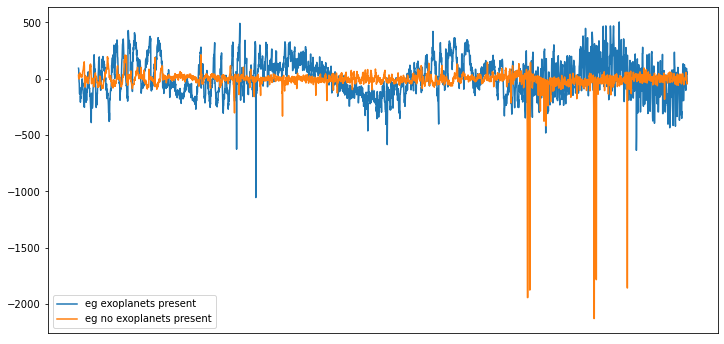

In [9]:
plt.figure(figsize=(12, 6))
ax = plt.gca() #get current axis
ax.axes.xaxis.set_visible(False)
plt.plot(df_train_trans_data[0], label='eg exoplanets present')
plt.plot(df_train_trans_data[100], label='eg no exoplanets present') #has no exoplanet
plt.legend()
plt.show()

- clearly visibile sinusodial wave in case of present exoplanet
- in both cases cleary visible outliers which should be adressed
- flux values have different magnitudes

## Machine Learning Model
### Baseline Models
- First check the difficulty of the problem with a couple of baseline models
    - No further preprocessing or hyperparameter tuning
    - Simple accracy score
- Split train data into train and validation data
    - For hyperparameter tuning I will use cross-validation instead

In [10]:
#Split into train and validate data
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, :1].values
y = y.reshape(y.shape[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

In [11]:
print(f'Samples in trainings data:\t{X_train.shape[0]}')
print(f'Samples in validation data:\t{X_val.shape[0]}')

Samples in trainings data:	4069
Samples in validation data:	1018


In [12]:
#list of baseline models
model_names = ["Logistic_Regression", "Random_Forest", "AdaBoost", "KNN", "Linear_SVC", "Naive_Bayes"]

model_list = [LogisticRegression()
               , RandomForestClassifier()
               , AdaBoostClassifier()
               , KNeighborsClassifier()
               , SVC(kernel="linear")
               , GaussianNB()]

In [40]:
#Filter input
X_train_filtered = wiener(X_train, mysize=15)
X_val_filtered = wiener(X_val, mysize=15)

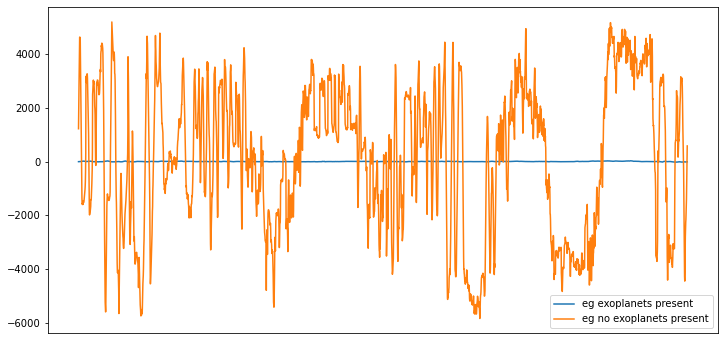

In [41]:
plt.figure(figsize=(12, 6))
ax = plt.gca() #get current axis
ax.axes.xaxis.set_visible(False)
plt.plot(X_train_filtered[0], label='eg exoplanets present')
plt.plot(X_train_filtered[100], label='eg no exoplanets present') #has no exoplanet
plt.legend()
plt.show()

In [42]:
#scale input
std_scaler = StandardScaler()
std_scaler.fit(X_train_filtered)
X_train_scaled = std_scaler.transform(X_train_filtered)
X_val_scaled = std_scaler.transform(X_val_filtered)

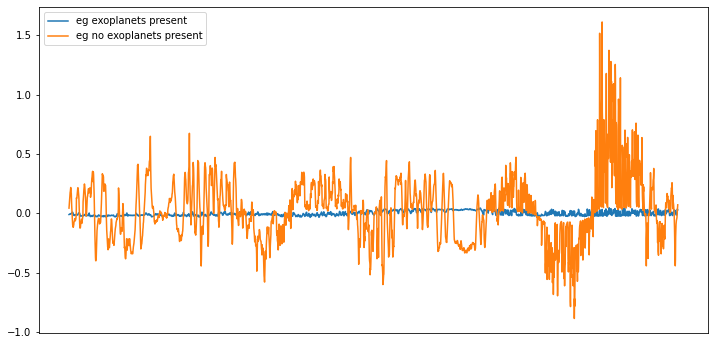

In [43]:
plt.figure(figsize=(12, 6))
ax = plt.gca() #get current axis
ax.axes.xaxis.set_visible(False)
plt.plot(X_train_scaled[0], label='eg exoplanets present')
plt.plot(X_train_scaled[100], label='eg no exoplanets present') #has no exoplanet
plt.legend()
plt.show()

In [44]:
#train and predict on baseline models

for i, model in enumerate(model_list):
    start = timer()
    model.fit(X_train_scaled, y_train)
    print(f'Model: {model_names[i]}')
    print(f'Trainings  Score:\t{model.score(X_train_scaled, y_train):0.4f}')
    print(f'Validation Score:\t{model.score(X_val_scaled, y_val):0.4f}')
    end = timer()
    print(f'Elapsed Time:\t{end - start:0.2f}s\n')

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.9926
Validation Score:	0.9912
Elapsed Time:	1.92s

Model: Random_Forest
Trainings  Score:	1.0000
Validation Score:	0.9931
Elapsed Time:	9.55s

Model: AdaBoost
Trainings  Score:	0.9951
Validation Score:	0.9902
Elapsed Time:	71.64s

Model: KNN
Trainings  Score:	0.9926
Validation Score:	0.9931
Elapsed Time:	54.47s

Model: Linear_SVC
Trainings  Score:	0.9929
Validation Score:	0.9921
Elapsed Time:	6.89s

Model: Naive_Bayes
Trainings  Score:	0.0499
Validation Score:	0.0393
Elapsed Time:	0.38s



- All models (except naive bayes) show very good results
- KNN and AdaBoost take to long to train
- Random Forest has highest accuracy while being resonable fast to train
- Next step is to improve perfomance of random forest further by tweaking the hyperparameters and preprocessing

### Baseline on Periodogram

In [53]:
#Calc periodogram
_, X_train_period = periodogram(X_train_scaled)
_, X_val_period = periodogram(X_val_scaled)

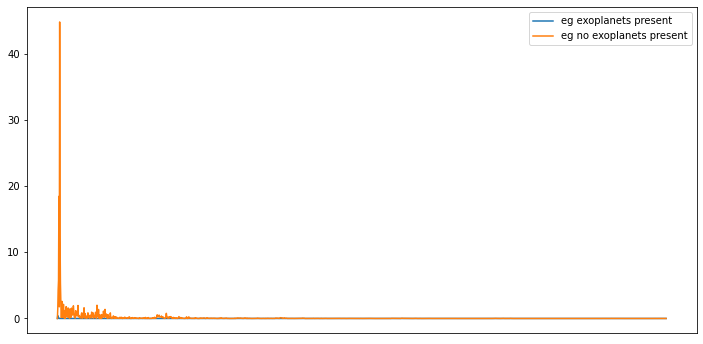

In [54]:
plt.figure(figsize=(12, 6))
ax = plt.gca() #get current axis
ax.axes.xaxis.set_visible(False)
plt.plot(X_train_period[0], label='eg exoplanets present')
plt.plot(X_train_period[100], label='eg no exoplanets present') #has no exoplanet
plt.legend()
plt.show()

In [55]:
for i, model in enumerate(model_list):
    start = timer()
    model.fit(X_train_period, y_train)
    print(f'Model: {model_names[i]}')
    print(f'Trainings  Score:\t{model.score(X_train_period, y_train):0.4f}')
    print(f'Validation Score:\t{model.score(X_val_period, y_val):0.4f}')
    end = timer()
    print(f'Elapsed Time:\t{end - start:0.2f}s\n')

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.9926
Validation Score:	0.9931
Elapsed Time:	0.43s

Model: Random_Forest
Trainings  Score:	0.9995
Validation Score:	0.9931
Elapsed Time:	8.02s

Model: AdaBoost
Trainings  Score:	0.9963
Validation Score:	0.9931
Elapsed Time:	29.98s

Model: KNN
Trainings  Score:	0.9926
Validation Score:	0.9931
Elapsed Time:	11.07s

Model: Linear_SVC
Trainings  Score:	0.9929
Validation Score:	0.9931
Elapsed Time:	4.57s

Model: Naive_Bayes
Trainings  Score:	0.0184
Validation Score:	0.0098
Elapsed Time:	0.22s



### Random Forest Classifier


#### Hyperparameter tuning with Random Search
Tune for
- Estimators
- max depth
- min leafs
- max features
- criterion

In [16]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                ,'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

#random search
forest_random_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X_train_period, y_train)

print(f'Training Score:\t{forest_random_cv.score(X_train_period, y_train)}')
print(f'Validate Score:\t{forest_random_cv.score(X_val_period, y_val)}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   25.2s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   31.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   38.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.9s finished


Training Score:	0.9926271811255837
Validate Score:	0.9931237721021611
Best model: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy'}


In [20]:
y_val_predicted = forest_random_cv.best_estimator_.predict(X_val_scaled)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

[[1011    0]
 [   7    0]]
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1011
        True       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018

0.9931237721021611


/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#lists of hyperparameters to tune
grid_params = {'criterion': [forest_random_cv.best_params_['criterion']]
                , 'max_features' : [forest_random_cv.best_params_['max_features']]
                ,'n_estimators' : [forest_random_cv.best_params_['n_estimators']]                   
                , 'max_depth' : [forest_random_cv.best_params_['max_depth'] - 5
                                , forest_random_cv.best_params_['max_depth']
                                , forest_random_cv.best_params_['max_depth'] + 5]
                , 'min_samples_leaf' : [forest_random_cv.best_params_['min_samples_leaf'] - 2
                                       , forest_random_cv.best_params_['min_samples_leaf']
                                       , forest_random_cv.best_params_['min_samples_leaf'] + 2]
                , 'min_samples_split': [forest_random_cv.best_params_['min_samples_split'] - 3
                                       , forest_random_cv.best_params_['min_samples_split']
                                       , forest_random_cv.best_params_['min_samples_split'] + 3]
              }

#grid search
forest_grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=3, n_jobs=-1, verbose=10)
forest_grid_cv.fit(X_train_scaled, y_train)

print(f'Training Score:\t{forest_grid_cv.score(X_train_scaled, y_train)}')
print(f'Validate Score:\t{forest_grid_cv.score(X_val_scaled, y_val)}')
print(f'Best model: {forest_grid_cv.best_params_}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed:  1.5min remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.6min finished


Training Score:	0.9938559842713197
Validate Score:	0.9931237721021611
Best model: {'criterion': 'entropy', 'max_depth': 95, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 500}


In [23]:
y_val_predicted = forest_grid_cv.best_estimator_.predict(X_val_scaled)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

[[1011    0]
 [   7    0]]
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1011
        True       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018

0.9931237721021611


/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
